# Building a tweet classifier using Transformers
This notebooks contains the experiments and details to building a pipeline that classifies tweets

In [9]:
from datasets import load_dataset
emotions = load_dataset('emotion')
ds_train = emotions['train']

In [10]:
print(emotions)
print('__'*40)
print(f'''Column names: {ds_train.column_names}
Number of samples in training data: {len(ds_train)}'''
)
for index in range(5):
    sample = ds_train[index]
    print(f'''
sample label: {sample['label']}
sample text: {sample['text']}''')
print('__'*40)
print(ds_train.features)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
________________________________________________________________________________
Column names: ['text', 'label']
Number of samples in training data: 16000

sample label: 0
sample text: i didnt feel humiliated

sample label: 0
sample text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake

sample label: 3
sample text: im grabbing a minute to post i feel greedy wrong

sample label: 2
sample text: i am ever feeling nostalgic about the fireplace i will know that it is still on the property

sample label: 3
sample text: i am feeling grouchy
________________________________________________________________________________
{'text': Value(dtype='string', i

In [11]:
for label, text in zip(ds_train['label'][:5], ds_train['text'][:5]):
    print(label, text)

0 i didnt feel humiliated
0 i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
3 im grabbing a minute to post i feel greedy wrong
2 i am ever feeling nostalgic about the fireplace i will know that it is still on the property
3 i am feeling grouchy


# Datasets to DataFrames

In [12]:
import pandas as pd
emotions.set_format(type='pandas')
df_emotions = emotions['train'][:]
df_emotions.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


What is **int2str**?
- It's a mapping function that maps a numerical labels to their string counter
part.
>  int2str function is typically used to convert integer sequences back into string sequences. It is commonly used in natural language processing tasks, such as machine translation or text generation.

In [13]:
# a function that takes a row's label and maps it to it's corresponding string
def map_label(row_label):
    return emotions['train'].features['label'].int2str(row_label)

In [14]:
df_emotions['label_name'] = df_emotions['label'].apply(map_label)
df_emotions.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Visualizing data for better understanding

In [15]:
import matplotlib.pyplot as plt

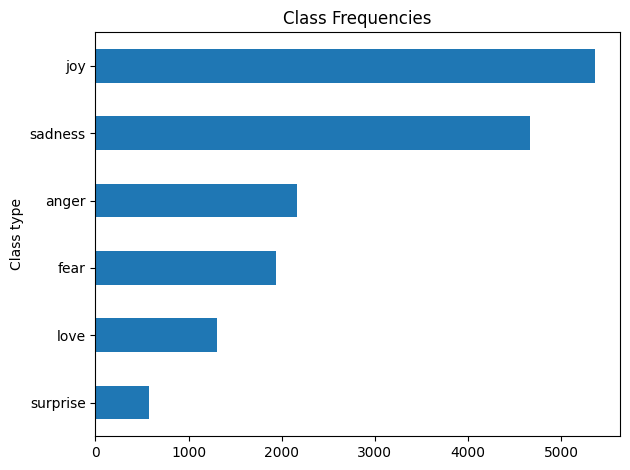

In [16]:
df_emotions['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Class Frequencies')
plt.ylabel('Class type')
plt.tight_layout()
plt.show();

From the plot above we can observe that the classes `joy` and `sadness` apear more
frequently, where as `love` and `surprise` are less frequent. This problem is commonly known as 
class imbalance and there are multiple ways to address it:
- Randomly oversample the minority class
- Randomly undersample the majority class
- Gather more labeled data from underrepresented classes.

There is a great sklearn library that addresses this issue [imbalanced-learn](https://imbalanced-learn.org/stable/).

**Converting text to tokens**
- Models usually cannot receive raw text as input instead they assume that text has been
tokenized and and encoded as numerical vectors

The different ways of tokenizing text are character, word and subword with the most effective being sub word tokenization..

In [17]:
from transformers import AutoTokenizer
model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [18]:
text = 'tokenization is a core task in NLP'
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 3989, 2003, 1037, 4563, 4708, 1999, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##ization', 'is', 'a', 'core', 'task', 'in', 'nl', '##p', '[SEP]']


In [20]:
# tokenizing the whole dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)
    # padding = True, this pads sequences in the same batch to the size of the longest one in the patch.
    # truncation = True, conversely this truncates sequences that are long than tokenize.model_max_length

In [21]:
emotions.set_format(None)
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Using Transformers as feature extractors

In [22]:
!pip install torch

In [23]:
from transformers import AutoModel
import torch
model_checkpoint = 'distilbert-base-uncased'
device_check = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_check)
print(f'current device is {device_check}')
model = AutoModel.from_pretrained(model_checkpoint).to(device)

current device is cpu


In [25]:
# getting the last hidden states
text = 'this is a text' # here n_tokens = 4 tokens + 2 special tokens
inputs = tokenizer(text, return_tensors='pt') # shape=[batch_size, n_tokens]
print(f'input tensor shape {inputs["input_ids"].size()}')
print(inputs)


input tensor shape torch.Size([1, 6])
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3793,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [30]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad(): # context manager
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2535, -0.1091,  0.0759,  ..., -0.1054,  0.2257,  0.4615],
         [-0.7154, -0.2742, -0.0954,  ..., -0.3597,  0.5174,  0.3450],
         [-0.4100, -0.2195,  0.1850,  ..., -0.0136,  0.1607,  1.0422],
         [-0.2523, -0.0254,  0.2472,  ..., -0.1637,  0.0865,  1.0516],
         [-0.0570, -0.1057,  0.0662,  ...,  0.0584,  0.1034,  0.2971],
         [ 0.9184,  0.1577, -0.4105,  ...,  0.1509, -0.7327, -0.1572]]]), hidden_states=None, attentions=None)


In [29]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor we see that it has the shape `[batch_size, n_tokens, hidden_dim]`